In [21]:
import duckdb
import pandas as pd
from pathlib import Path

# Setup

In [2]:
duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    description = conn.sql("DESC;").df()
    films = conn.sql("FROM film;").df()

films

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,<NA>,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2021-03-06 15:52:00
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,<NA>,6,2.99,130,22.99,G,Deleted Scenes,2021-03-06 15:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,A Unbelieveable Yarn of a Boat And a Database ...,2006,1,<NA>,6,0.99,183,9.99,G,"Trailers,Behind the Scenes",2021-03-06 15:52:08
996,997,YOUTH KICK,A Touching Drama of a Teacher And a Cat who mu...,2006,1,<NA>,4,0.99,179,14.99,NC-17,"Trailers,Behind the Scenes",2021-03-06 15:52:08
997,998,ZHIVAGO CORE,A Fateful Yarn of a Composer And a Man who mus...,2006,1,<NA>,6,0.99,105,10.99,NC-17,Deleted Scenes,2021-03-06 15:52:08
998,999,ZOOLANDER FICTION,A Fateful Reflection of a Waitress And a Boat ...,2006,1,<NA>,5,2.99,101,28.99,R,"Trailers,Deleted Scenes",2021-03-06 15:52:08


In [3]:
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in description['name']:
        dfs[name] = conn.sql(f"FROM {name};").df()

In [4]:
dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

In [5]:
dfs["actor"].head(3)

,actor_id,first_name,last_name,last_update
0,1.0,PENELOPE,GUINESS,2021-03-06 15:51:59
1,2.0,NICK,WAHLBERG,2021-03-06 15:51:59
2,3.0,ED,CHASE,2021-03-06 15:51:59


In [6]:
for table_name in ["film", "film_actor", "film_category", "actor", "category"]:
    duckdb.register(table_name, dfs[table_name])

duckdb.sql("DESCRIBE").df()

,database,schema,name,column_names,column_types,temporary
0,temp,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",True
1,temp,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",True
2,temp,main,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",True
3,temp,main,film_actor,"[actor_id, film_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True
4,temp,main,film_category,"[film_id, category_id, last_update]","[BIGINT, BIGINT, TIMESTAMP]",True


# Task 1 - EDA in python

## Task 1a

For the tasks, I wanted to have a clean look, but had to at times add labels like "print()" since it wasn't cooperating

In [73]:
# a) Movies longer than 3 hours (180 minutes)

task1a = duckdb.sql(
    """
    SELECT title, length
    FROM film 
    WHERE length > 180
    ORDER BY length DESC;
"""
).df()

print("=== Task 1a: Movies longer than 3 hours ===")
print(f"Found {len(task1a)} movies")
task1a.head(10)

=== Task 1a: Movies longer than 3 hours ===
Found 39 movies


,title,length
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185
5,GANGS PRIDE,185
6,HOME PITY,185
7,SOLDIERS EVOLUTION,185
8,POND SEATTLE,185
9,MUSCLE BRIGHT,185


# Task 1b

In [58]:
# b) Movies with only 'love' in its title

task1b = duckdb.sql(
    """
    SELECT title, rating, length, description
    FROM film
    WHERE REGEXP_MATCHES(title, '\\blove\\b', 'i')
    ORDER BY title;
""").df()

print("=== Task 1b: Movies with only 'love' in its title ===")
print(f"Found {len(task1b)} movies")
task1b

=== Task 1b: Movies with only 'love' in its title ===
Found 5 movies


,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


# Task 1c

In [66]:
# c) Descriptive statistics on movie length column

task1c = duckdb.sql(
    """
    SELECT 
        MIN(length) AS shortest,
        AVG(length) AS average,
        Percentile_Cont(0.0) WITHIN GROUP (ORDER BY length) AS median,
        MAX(length) AS longest
    FROM film;
""").df()

print("=== Task 1c: Descriptive statistics on movie length column ===")
task1c

=== Task 1c: Descriptive statistics on movie length column ===


,shortest,average,median,longest
0,46,115.272,46.0,185


# Task 1d

In [68]:
# d) 10 most expensive movies to rent per day

task1d = duckdb.sql(
    """
    SELECT
        title, 
        rental_rate,
        rental_duration,
        Round(rental_rate / rental_duration, 2) AS cost_per_day
    FROM film
    ORDER BY cost_per_day DESC
    LIMIT 10;
""").df()

print("=== Task 1d: 10 most expensive movies to rent per day ===")
task1d

=== Task 1d: 10 most expensive movies to rent per day ===


,title,rental_rate,rental_duration,cost_per_day
0,AMERICAN CIRCUS,4.99,3,1.66
1,BACKLASH UNDEFEATED,4.99,3,1.66
2,BILKO ANONYMOUS,4.99,3,1.66
3,BEAST HUNCHBACK,4.99,3,1.66
4,CARIBBEAN LIBERTY,4.99,3,1.66
5,AUTUMN CROW,4.99,3,1.66
6,CASPER DRAGONFLY,4.99,3,1.66
7,ACE GOLDFINGER,4.99,3,1.66
8,BEHAVIOR RUNAWAY,4.99,3,1.66
9,CASUALTIES ENCINO,4.99,3,1.66


# Task 1e

In [8]:
# e) Actors who played in most movies

task1e = duckdb.sql(
    """
    SELECT 
        a.first_name || ' ' || a.last_name AS actor_name,
        COUNT(fa.film_id) AS movie_count
    FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY movie_count DESC
    LIMIT 10;
""").df()

print("=== Task 1e: Actors who played in most movies ===")
task1e

=== Task 1e: Actors who played in most movies ===


,actor_name,movie_count
0,GINA DEGENERES,42
1,WALTER TORN,41
2,MARY KEITEL,40
3,MATTHEW CARREY,39
4,SANDRA KILMER,37
5,SCARLETT DAMON,36
6,VIVIEN BASINGER,35
7,GROUCHO DUNST,35
8,HENRY BERRY,35
9,ANGELA WITHERSPOON,35


# Task 1f
## 3-5 of my own questions

In [37]:
# Question 1: What are the most popular film categories?
q1 = duckdb.sql(
    """
    SELECT
        c.name as category, 
        COUNT(fc.film_id) AS film_count
    FROM category c
    JOIN film_category fc ON c.category_id = fc.category_id
    GROUP BY c.category_id, c.name
    ORDER by film_count DESC;
""").df()

q1.info()
q1['category'].value_counts()
q1['film_count'].describe()
q1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    16 non-null     object
 1   film_count  16 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 388.0+ bytes


,category,film_count
0,Sports,74
1,Foreign,73
2,Family,69
3,Documentary,68
4,Animation,66


In [34]:
# Question 2: How many movies per rating?
q2 = duckdb.sql(
    """
    SELECT
        rating,
        COUNT(*) as movie_count,
        AVG(length) as avg_length,
        AVG(rental_rate) as avg_rental_rate
    FROM film
    GROUP BY rating
    ORDER BY movie_count DESC;
""").df()

q2.info()
q2['rating'].value_counts()
q2['movie_count'].describe()
q2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rating           5 non-null      object 
 1   movie_count      5 non-null      int64  
 2   avg_length       5 non-null      float64
 3   avg_rental_rate  5 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 292.0+ bytes


,rating,movie_count,avg_length,avg_rental_rate
0,PG-13,223,120.443946,3.034843
1,NC-17,210,113.228571,2.970952
2,R,195,118.661538,2.938718
3,PG,194,112.005155,3.051856
4,G,178,111.050562,2.888876


In [38]:
# Some questions didn't work, since not all tables were seemingly transferred
# With the help of LLMs, this test answered that question for me

all_tables = duckdb.sql("SHOW TABLES").df()
print("All tables in database:")
all_tables

table_list = all_tables['name'].tolist()
print("Table names:")
for table in table_list:
    print(f"  - {table}")

# Now time for some new questions

All tables in database:
Table names:
  - actor
  - category
  - film
  - film_actor
  - film_category


In [43]:
# Question 3: Which actors appear in the most diverse categories?
q3 = duckdb.sql(
    """
    SELECT 
        a.first_name || ' ' || a.last_name as actor_name,
        COUNT(DISTINCT c.name) as unique_categories,
        COUNT(fa.film_id) as total_movies
    FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    JOIN film_category fc ON fa.film_id = fc.film_id
    JOIN category c ON fc.category_id = c.category_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY unique_categories DESC, total_movies DESC
    LIMIT 10;
""").df()

q3.info()
q3['actor_name'].value_counts()
q3['unique_categories'].describe()
q3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   actor_name         10 non-null     object
 1   unique_categories  10 non-null     int64 
 2   total_movies       10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 372.0+ bytes


,actor_name,unique_categories,total_movies
0,GINA DEGENERES,16,42
1,GROUCHO DUNST,16,35
2,UMA WOOD,16,35
3,KEVIN GARLAND,16,33
4,EWAN GOODING,16,33
5,REESE WEST,16,33
6,HARVEY HOPE,16,32
7,DARYL WAHLBERG,16,31
8,IAN TANDY,16,31
9,MICHAEL BOLGER,16,30


In [41]:
# Question 4: Which actor pairs appear together in most films?
q4 = duckdb.sql(
    """
    SELECT
        a1.first_name || ' ' || a1.last_name as actor1,
        a2.first_name || ' ' || a2.last_name as actor2,
        COUNT(DISTINCT f.film_id) as films_together
    FROM film_actor fa1
    JOIN film_actor fa2 ON fa1.film_id = fa2.film_id AND fa1.actor_id < fa2.actor_id
    JOIN actor a1 ON fa1.actor_id = a1.actor_id
    JOIN actor a2 ON fa2.actor_id = a2.actor_id
    JOIN film f ON fa1.film_id = f.film_id
    GROUP BY a1.actor_id, a1.first_name, a1.last_name, 
             a2.actor_id, a2.first_name, a2.last_name
    ORDER BY films_together DESC
    LIMIT 10;
""").df()

q4.info()
q4['actor1'].value_counts().head()
q4['actor2'].value_counts().head()
q4['films_together'].describe()
q4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   actor1          10 non-null     object
 1   actor2          10 non-null     object
 2   films_together  10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes


,actor1,actor2,films_together
0,JULIA MCQUEEN,HENRY BERRY,7
1,BEN WILLIS,HARVEY HOPE,6
2,KIRSTEN PALTROW,WARREN NOLTE,6
3,VAL BOLGER,ROCK DUKAKIS,6
4,MORGAN MCDORMAND,WILL WILSON,6
5,CUBA OLIVIER,MARY KEITEL,6
6,SYLVESTER DERN,JEFF SILVERSTONE,5
7,SUSAN DAVIS,ROCK DUKAKIS,5
8,DARYL CRAWFORD,HARVEY HOPE,5
9,CARMEN HUNT,MARY TANDY,5


# Task 2 - graphs

## Loading additional tables for task 2

In [22]:
import duckdb
import pandas as pd
from pathlib import Path

In [23]:
from pathlib import Path

sqlite_path = "data/sqlite-sakila.db"
print(f"Checking for file: {sqlite_path}")
print(f"File exists: {Path(sqlite_path).exists()}")

Checking for file: data/sqlite-sakila.db
File exists: True


In [ ]:
# Similarly to task 1f, I ran into some missing tables
# And therefore I had to tweak them with not only the help of previous courses and classmates, but also LLMs as last resort when other things failed

#Loading missing tables
tables_to_load = ['customer', 'payment', 'rental', 'inventory', 'address', 'staff', 'store']

for table in tables_to_load:
    try:
        # This time trying direct query first
        test = duckdb.sql(f"SELECT * FROM {table} LIMIT 1").df()
        print(f"Table '{table}' exists")
    except:
        # If NOT EXISTS, try loading from file
        try:
            query = f"""
                SELECT * 
                FROM read_sqlite('data/sqlite-sakila.db', 
                     'SELECT * FROM {table}')
            """
            df = duckdb.sql(query).df()
            duckdb.register(table, df)
            print(f"Loaded {table}: {df.shape[0]} rows")
        except Exception as e:
            print(f"Failed to load {table}: {e}")


Table 'customer' exists
Table 'payment' exists
Table 'rental' exists
Table 'inventory' exists
Table 'address' exists
Table 'staff' exists
Table 'store' exists


In [29]:
# Testing to see if the customer table has loaded
try:
    test_customer = duckdb.sql("SELECT * FROM customer LIMIT 3").df()
    print("Customer table exists:")
    test_customer
except Exception as e:
    print(f"Customer table error: {e}")

Customer table exists:


## Task 2a

In [35]:
# a) Top 5 customers by total spend

task2a = duckdb.sql(
    """
    SELECT 
        c.customer_id,
        c.first_name || ' ' || c.last_name as customer_name,
        SUM(p.amount) as total_spend
    FROM customer c
    JOIN payment p ON c.customer_id = p.customer_id
    GROUP BY c.customer_id, c.first_name, c.last_name
    ORDER BY total_spend DESC
    LIMIT 5;
""").df()

task2a

,customer_id,customer_name,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,178,MARION SNYDER,194.61
4,137,RHONDA KENNEDY,194.61


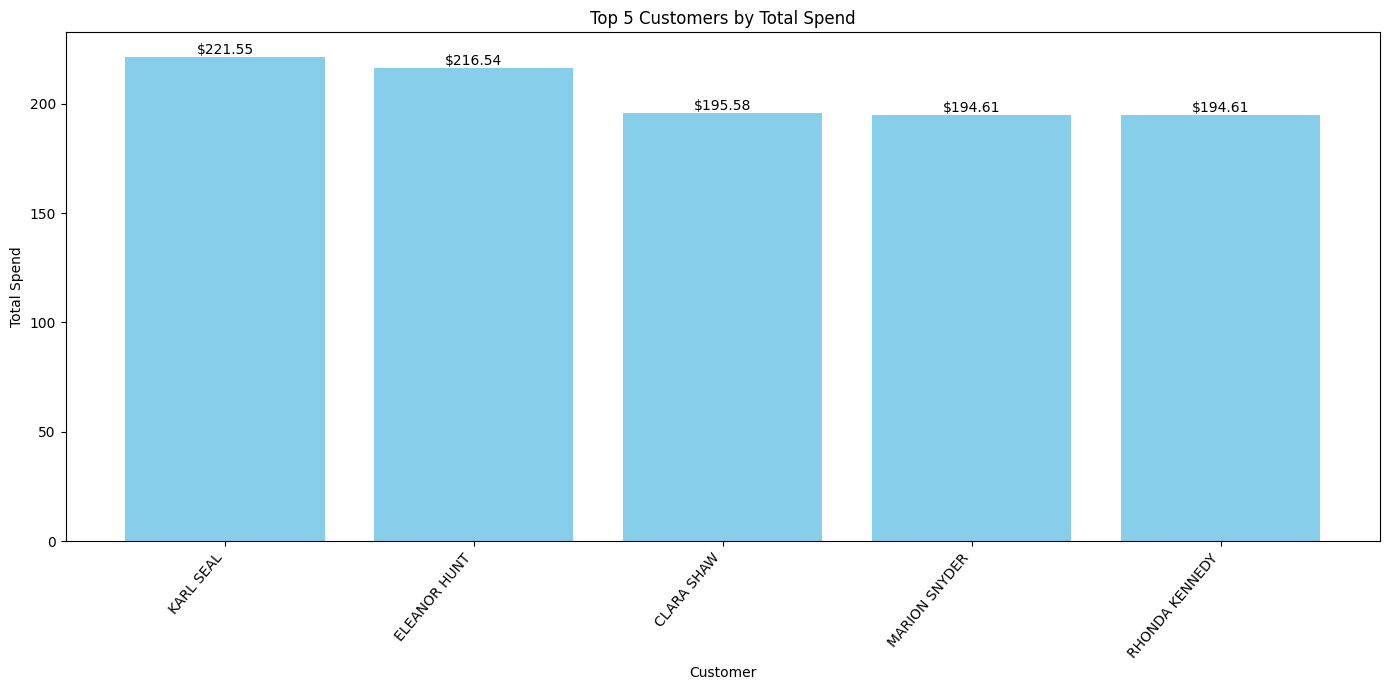

In [43]:
# Creating a bar chart for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
bars = plt.bar(task2a['customer_name'], task2a['total_spend'], color='skyblue')
plt.xlabel('Customer')
plt.ylabel('Total Spend')
plt.title('Top 5 Customers by Total Spend')
plt.xticks(rotation=50, ha='right')

# Adding value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'${height:.2f}', 
             ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

## Task 2b

In [40]:
# Task 2b: Total revenue per film category

task2b = duckdb.sql(
    """
    SELECT 
        c.name as category,
        SUM(p.amount) as total_revenue
    FROM category c
    JOIN film_category fc ON c.category_id = fc.category_id
    JOIN film f ON fc.film_id = f.film_id
    JOIN inventory i ON f.film_id = i.film_id
    JOIN rental r ON i.inventory_id = r.inventory_id
    JOIN payment p ON r.rental_id = p.rental_id
    GROUP BY c.name
    ORDER BY total_revenue DESC
""").df()

task2b

,category,total_revenue
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


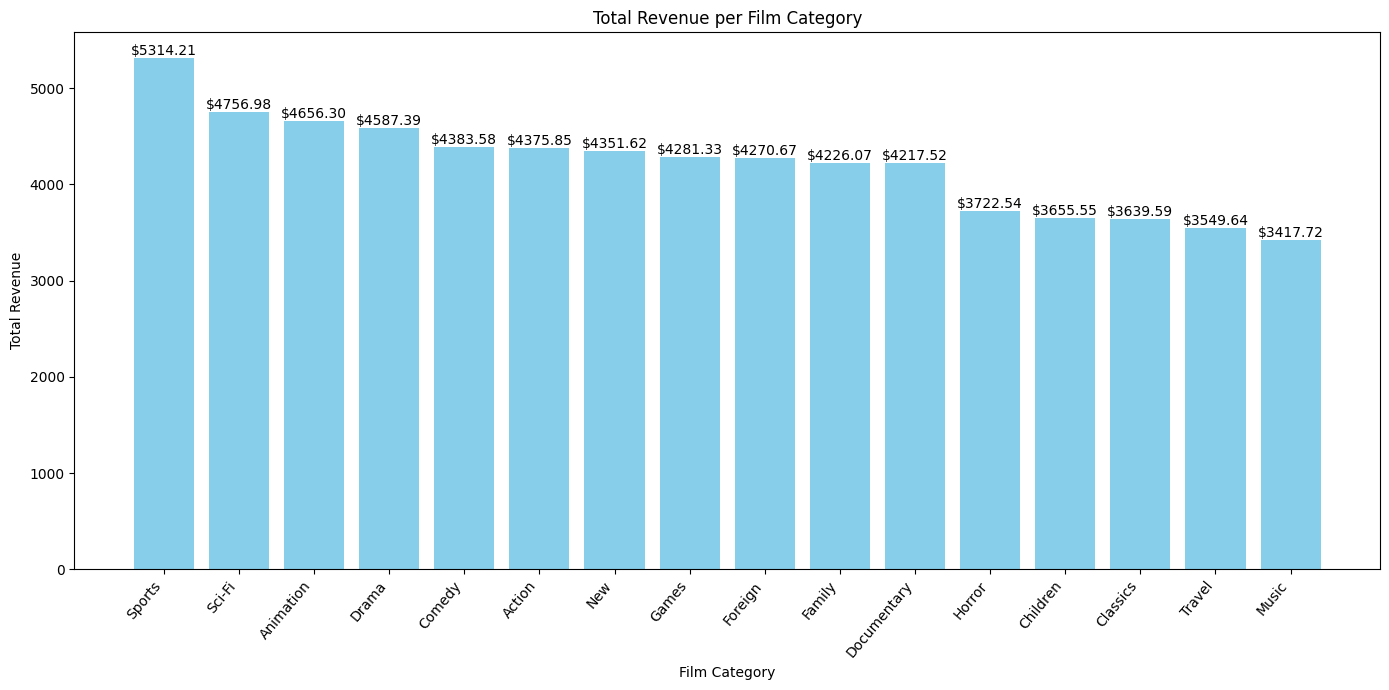

In [42]:
# Creating a bar chart for visualization
plt.figure(figsize=(14,7))
bars = plt.bar(task2b['category'], task2b['total_revenue'], color='skyblue')
plt.xlabel('Film Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Film Category')
plt.xticks(rotation=50, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'${height:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()